In [146]:
!pip install seaborn

     |████████████████████████████████| 292 kB 30.1 MB/s            01


In [1]:
import pandas as pd
import konlpy

import matplotlib.pyplot as plt
import seaborn

In [2]:
import os

In [3]:
os.path.exists('/aihub/data/')
os.listdir('/aihub')

['data', 'workspace']

In [4]:
mecab = konlpy.tag.Mecab()

In [87]:
spam = pd.read_csv('data/spam.csv')

In [88]:
spam_test = pd.read_csv('data/spam_test_text.csv', index_col=0).reset_index(drop=True)
spam_test_label = pd.read_csv('data/spam_test_label.csv', index_col=0).reset_index(drop=True)
spam_test.isna().sum()

text    0
dtype: int64

In [89]:
spam_test = pd.concat([spam_test, spam_test_label], axis=1)

In [90]:
spam.dropna(inplace=True)
spam_test.dropna(inplace=True)

In [64]:
spam.text = spam.text.replace(r'[^가-힣]', r' ', regex=True)
spam_test.text = spam_test.text.replace(r'[^가-힣]', r'', regex=True)

In [91]:
spam.label = spam.label.replace({'spam': 1, 'ham': 0})

spam.text = spam.text.apply(mecab.nouns)
spam.text = spam.text.apply(lambda x: ' '.join(x))

In [92]:
spam_test.label = spam_test.label.replace({'spam': 1, 'ham': 0})

spam_test.text = spam_test.text.apply(lambda x: mecab.nouns(x))
spam_test.text = spam_test.text.apply(lambda x: ' '.join(x))

In [93]:
spam_test

,text,label
0,발신 광고 강남 시 셔츠 대륙 쵸 이스 문의 홈 무료 거부,1
1,발신 광고 님 당 무료 거부,1
2,발신 이태용 월일 자전 정보 본전,1
3,발신 달서구 마지막 억대 분양 성당 태왕 너스 평형 순위 접수 중 청약 통장 주택 가능,1
4,발신 광고 개인 업 오늘 하루 연체 부결 카카오 무료 거부,1
...,...,...
9891,발신 냉온 정수기 원비 데원 공기 청정기 평원 제습기 원 전기 렌 지원,0
9892,광고 스파클 유흥 다이소 선정릉 모바일 앱 무료 거부,1
9893,광고 주행 배정 무료 수신 거부,1
9894,광고 수산 문자 쿠폰 행사 킹크 랩 원 원 물량 소진 시 무료 거부,0


In [94]:
from sklearn.model_selection import *
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

In [95]:
X_train, X_test, y_train, y_test = train_test_split(spam.text, spam.label, test_size=.2, random_state=2022)

In [202]:
ngram = make_pipeline(CountVectorizer(ngram_range=(1, 3)), 
                      TfidfTransformer(), 
                      MultinomialNB())

In [203]:
ngram.fit(spam.text, spam.label)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [204]:
ngram.score(X_test, y_test)

0.9661523145843703

In [205]:
f1_score(y_test, ngram.predict(X_test))

0.9742424242424242

In [206]:
y_pred = ngram.predict(spam_test.text)

In [184]:
# r'[^가-힣]' -> r' '
f1_score(spam_test.label, y_pred)

0.9211877651261443

In [207]:
# r'[^가-힣]' -> r''
f1_score(spam_test.label, y_pred)

0.9222180870859695

In [168]:
# 기본 mecab.nouns
f1_score(spam_test.label, y_pred)

0.926443133447838

In [47]:
y_pred_df = pd.DataFrame(y_pred, columns=['label']).replace({1:'spam', 0:'ham'}).reset_index(drop=False).rename(columns={'index': 'id'})

In [62]:
spam_test

,text,label
0,발신 광고 강남 시 셔츠 대륙 쵸 이스 문의 홈 무료 거부,1
1,발신 광고 님 당 무료 거부,1
2,발신 이태용 월일 자전 정보 본전,1
3,발신 달서구 마지막 억대 분양 성당 태왕 너스 평형 순위 접수 중 청약 통장 주택 가능,1
4,발신 광고 개인 업 오늘 하루 연체 부결 카카오 무료 거부,1
...,...,...
9891,발신 냉온 정수기 원비 데원 공기 청정기 평원 제습기 원 전기 렌 지원,0
9892,광고 스파클 유흥 다이소 선정릉 모바일 앱 무료 거부,1
9893,광고 주행 배정 무료 수신 거부,1
9894,광고 수산 문자 쿠폰 행사 킹크 랩 원 원 물량 소진 시 무료 거부,0


In [245]:
y_pred_df.to_csv("/aihub/data/submission.csv",index=False)

In [69]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 32000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

X_train_seq, X_test_seq, _ = sequence_vectorize(X_train, X_test)

In [96]:
tokenizer = text.Tokenizer(16215)
tokenizer.fit_on_texts(X_train)
vocab_size = 16215

In [97]:
word_to_index = tokenizer.word_index
len(word_to_index)

16215

In [98]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 8237
단어 집합(vocabulary)에서 희귀 단어의 비율: 50.7986432315757
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0


In [99]:
tokenizer = text.Tokenizer(num_words = total_cnt - rare_cnt + 1) #1번 이하로 등장하는 단어는 제외
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)# 단어를 숫자값, 인덱스로 변환하여 저장

In [100]:
X_train_seq = tokenizer.texts_to_sequences(X_train)

In [101]:
X_test_seq = tokenizer.texts_to_sequences(X_test)

메일의 최대 길이 : 40
메일의 평균 길이 : 10.032045


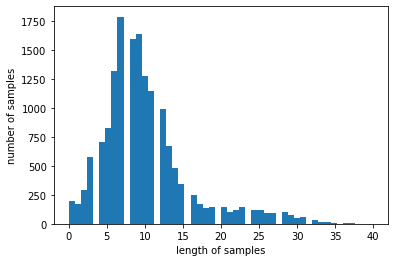

In [102]:
print('메일의 최대 길이 : %d' % max(len(l) for l in X_train_seq))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_seq))/len(X_train_seq)))

plt.hist([len(s) for s in X_train_seq], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [103]:
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=40)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=40)

메일의 최대 길이 : 40
메일의 평균 길이 : 40.000000


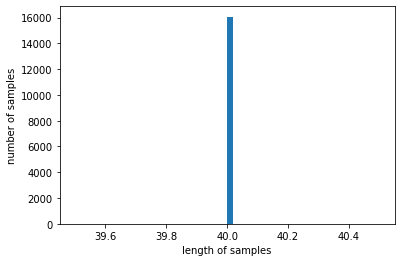

In [104]:
print('메일의 최대 길이 : %d' % max(len(l) for l in X_train_seq))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_seq))/len(X_train_seq)))

plt.hist([len(s) for s in X_train_seq], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [105]:
vocab_size = total_cnt - rare_cnt + 1
vocab_size

7979

In [29]:
# # Conv1D로 학습하고 모델 성능을 검증합니다.


# from tensorflow.python.keras import models
# from tensorflow.python.keras import initializers
# from tensorflow.python.keras import regularizers

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.layers import Dropout
# from tensorflow.python.keras.layers import Embedding
# from tensorflow.python.keras.layers import SeparableConv1D
# from tensorflow.python.keras.layers import MaxPooling1D
# from tensorflow.python.keras.layers import GlobalAveragePooling1D

# def sepcnn_model(blocks,
#                  filters,
#                  kernel_size,
#                  embedding_dim,
#                  dropout_rate,
#                  pool_size,
#                  input_shape,
#                  num_classes,
#                  num_features,
#                  use_pretrained_embedding=False,
#                  is_embedding_trainable=False,
#                  embedding_matrix=None):
#     """Creates an instance of a separable CNN model.

#     # Arguments
#         blocks: int, number of pairs of sepCNN and pooling blocks in the model.
#         filters: int, output dimension of the layers.
#         kernel_size: int, length of the convolution window.
#         embedding_dim: int, dimension of the embedding vectors.
#         dropout_rate: float, percentage of input to drop at Dropout layers.
#         pool_size: int, factor by which to downscale input at MaxPooling layer.
#         input_shape: tuple, shape of input to the model.
#         num_classes: int, number of output classes.
#         num_features: int, number of words (embedding input dimension).
#         use_pretrained_embedding: bool, true if pre-trained embedding is on.
#         is_embedding_trainable: bool, true if embedding layer is trainable.
#         embedding_matrix: dict, dictionary with embedding coefficients.

#     # Returns
#         A sepCNN model instance.
#     """
#     # op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
#     model = models.Sequential()

#     # Add embedding layer. If pre-trained embedding is used add weights to the
#     # embeddings layer and set trainable to input is_embedding_trainable flag.
#     if use_pretrained_embedding:
#         model.add(Embedding(input_dim=num_features,
#                             output_dim=embedding_dim,
#                             input_length=input_shape[0],
#                             weights=[embedding_matrix],
#                             trainable=is_embedding_trainable))
#     else:
#         model.add(Embedding(input_dim=num_features,
#                             output_dim=embedding_dim,
#                             input_length=input_shape[0]))

#     for _ in range(blocks-1):
#         model.add(Dropout(rate=dropout_rate))
#         model.add(SeparableConv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   bias_initializer='random_uniform',
#                                   depthwise_initializer='random_uniform',
#                                   padding='same'))
#         model.add(SeparableConv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   bias_initializer='random_uniform',
#                                   depthwise_initializer='random_uniform',
#                                   padding='same'))
#         model.add(MaxPooling1D(pool_size=pool_size))

#     model.add(SeparableConv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               bias_initializer='random_uniform',
#                               depthwise_initializer='random_uniform',
#                               padding='same'))
#     model.add(SeparableConv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               bias_initializer='random_uniform',
#                               depthwise_initializer='random_uniform',
#                               padding='same'))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dropout(rate=dropout_rate))
#     model.add(Dense(2, activation='softmax'))
#     return model

In [30]:
# dl_model = sepcnn_model(blocks = 3,
#                         filters = 5,
#                         kernel_size = 3,
#                         embedding_dim = 4,
#                         dropout_rate = .2,
#                         pool_size = 2,
#                         input_shape = (40, ),
#                         num_classes = 2,
#                         num_features = 5,
#                         )

In [31]:
from tensorflow import keras

In [32]:
# sequence.pad_sequences(X_train_seq, maxlen=40)

array([[   0,    0,    0, ...,  626,   79, 1105],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,  144,   46,  491],
       ...,
       [   0,    0,    0, ...,   49,    3,    4],
       [   0,    0,    0, ...,   99,  130,  192],
       [   0,    0,    0, ...,  188,   77,   29]], dtype=int32)

In [33]:
# dl_model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy', 'f1_score'])

In [36]:
# es = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                    min_delta=0,
#                                    patience=3,
#                                    restore_best_weights=True,
#                                   )

In [ ]:
# dl_model.fit(x = X_train_seq, y = y_train, 
#              validation_data=(X_test, y_test), 
#              epochs=100, 
#              callbacks=[es])

In [38]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

keras.backend.clear_session()

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
for _ in range(5):
    model.add(Dropout(.2))
    model.add(SeparableConv1D(filters=32,
                              kernel_size=3,
                              activation='relu',
                              padding='same'
                             ))
    model.add(SeparableConv1D(filters=32,
                              kernel_size=3,
                              activation='relu',
                              padding='same'
                             ))
    model.add(MaxPooling1D(pool_size=2))
model.add(GlobalAveragePooling1D())
model.add(Dropout(.2))
model.add(Dense(1024, activation='relu'))
# model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, y_train, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(X_test_seq, y_test), 
                    callbacks=[es])

Epoch 1/100
252/252 [==============================] - 8s 25ms/step - loss: 0.6611 - accuracy: 0.6321 - val_loss: 0.6545 - val_accuracy: 0.6404
Epoch 2/100
252/252 [==============================] - 6s 24ms/step - loss: 0.6547 - accuracy: 0.6386 - val_loss: 0.6543 - val_accuracy: 0.6404
Epoch 3/100
252/252 [==============================] - 6s 24ms/step - loss: 0.6583 - accuracy: 0.6319 - val_loss: 0.6535 - val_accuracy: 0.6404
Epoch 4/100
252/252 [==============================] - 6s 23ms/step - loss: 0.6568 - accuracy: 0.6347 - val_loss: 0.6533 - val_accuracy: 0.6404
Epoch 5/100
252/252 [==============================] - 6s 22ms/step - loss: 0.6555 - accuracy: 0.6377 - val_loss: 0.6533 - val_accuracy: 0.6404
Epoch 6/100
252/252 [==============================] - 6s 23ms/step - loss: 0.6593 - accuracy: 0.6301 - val_loss: 0.6535 - val_accuracy: 0.6404
Epoch 7/100
252/252 [==============================] - 6s 23ms/step - loss: 0.6578 - accuracy: 0.6332 - val_loss: 0.6540 - val_accuracy:

In [106]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

keras.backend.clear_session()

model = Sequential()
model.add(Embedding(vocab_size, 64)) # 임베딩 벡터의 차원은 32
for _ in range(2):
    model.add(Dropout(.2))
    model.add(SeparableConv1D(filters=32 * (_+1),
                              kernel_size=5,
                              activation='relu',
                              padding='same'
                             ))
    model.add(SeparableConv1D(filters=32 * (_+1),
                              kernel_size=5,
                              activation='relu',
                              padding='same'
                             ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(SeparableConv1D(filters=128,
                          kernel_size=5,
                          activation='relu',
                          padding='same'
                         ))
model.add(SeparableConv1D(filters=128,
                          kernel_size=5,
                          activation='relu',
                          padding='same'
                         ))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(.2))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
# model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, y_train, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(X_test_seq, y_test), 
                    callbacks=[es])

Epoch 1/100
252/252 [==============================] - 17s 62ms/step - loss: 0.4704 - accuracy: 0.7635 - val_loss: 0.6685 - val_accuracy: 0.6404
Epoch 2/100
252/252 [==============================] - 15s 61ms/step - loss: 0.1354 - accuracy: 0.9534 - val_loss: 0.6201 - val_accuracy: 0.6404
Epoch 3/100
252/252 [==============================] - 15s 61ms/step - loss: 0.0812 - accuracy: 0.9740 - val_loss: 1.4224 - val_accuracy: 0.6862
Epoch 4/100
252/252 [==============================] - 16s 62ms/step - loss: 0.0516 - accuracy: 0.9811 - val_loss: 0.3869 - val_accuracy: 0.8686
Epoch 5/100
252/252 [==============================] - 16s 63ms/step - loss: 0.0491 - accuracy: 0.9824 - val_loss: 0.7074 - val_accuracy: 0.8280
Epoch 6/100
252/252 [==============================] - 16s 62ms/step - loss: 0.0443 - accuracy: 0.9860 - val_loss: 0.6946 - val_accuracy: 0.8793
Epoch 7/100
252/252 [==============================] - 16s 62ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 1.8736 - val_ac

In [107]:
X_kaggle = tokenizer.texts_to_sequences(spam_test.text)
X_kaggle = sequence.pad_sequences(X_kaggle, maxlen=40)
y_pred = model.predict(X_kaggle)
y_pred

array([[9.8069239e-01],
       [9.5803142e-01],
       [9.8034739e-01],
       ...,
       [8.5434705e-01],
       [3.6208868e-02],
       [6.1578190e-05]], dtype=float32)

In [108]:
y_pred_df = pd.DataFrame(y_pred, columns=['label']).reset_index(drop=False).rename(columns={'index': 'id'})

In [109]:
y_pred_df.label = y_pred_df.label.apply(round)

y_pred_df.label.value_counts()

1    5227
0    4669
Name: label, dtype: int64

In [85]:
f1_score(spam_test.label, y_pred_df.label)

0.930681818181818

In [86]:
# DL: r'[^가-힣]' -> r' '
f1_score(spam_test.label, y_pred_df.label)

0.930681818181818

In [58]:
# DL: r'[^가-힣]' -> r''
f1_score(spam_test.label, y_pred_df.label)

0.9415474169294203

In [110]:
# DL: 기본 mecab.nouns
f1_score(spam_test.label, y_pred_df.label)

0.8923929994801593

In [442]:
y_pred_df.label = y_pred_df.label.replace({1:'spam', 0:'ham'})

y_pred_df


,id,label
0,0,spam
1,1,spam
2,2,spam
3,3,spam
4,4,spam
...,...,...
9891,9891,ham
9892,9892,spam
9893,9893,spam
9894,9894,ham


In [ ]:
y_pred_df.to_csv("/aihub/data/submission.csv",index=False)